In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix, mean_squared_error, r2_score, accuracy_score, roc_curve, auc)
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


In [2]:
df = pd.read_csv("machine_failure.csv")

In [3]:
df.shape

(10000, 14)

In [4]:
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


**Dataset overview:**

**Sensor/Operational Inputs:**

- **A Unique Identifier (UID)** that ranges from 1 to 10000  
- **Product ID**, consisting of a letter **L** (for low), **M** (for medium), or **H** (for high), to indicate the product quality variant, and a variant-specific serial number.  
- **Air temperature**, in degrees Kelvin (K)  
- **Process Temperature**, in degrees Kelvin  
- **Rotational Speed**, in revolutions per minute (RPM)  
- **Torque**, in Newton-Meters (Nm)  
- **Tool wear**, in minutes. The quality variants **H**, **M**, and **L** add **5**, **3**, and **2** minutes of tool wear respectively to the tool used in the process  

**A Machine Failure Label**, to indicate whether the machine failed in the specific df point. This specific df point can have any of the following five independent failure modes:

- **Tool Wear Failure (TWF)**: the tool is replaced or fails at a randomly selected tool wear time, between 200 and 240 minutes  
- **Heat Dissipation Failure (HDF)**: heat dissipation causes a process failure if the difference between the air temperature and the process temperature is less than 8.6 K, and the tool's rotational speed is less than 1380 RPM  
- **Power Failure (PWF)**: the product of torque and rotational speed (in rad/s) equals the power required for the process. The process fails if this power falls below 3,500 W or exceeds 9,000 W  
- **OverStrain Failure (OSF)**: if the product of tool wear and torque exceeds 11,000 minimum Nm for the **L** product variant (12,000 for **M**, 13,000 for **H**), the process fails due to overstrain  
- **Random Failures (RNF)**: each process has a failure chance of 0.1%, regardless of the process parameters

In [5]:
#Removing special characters from column names
df = df.rename(columns={'Product ID': 'Product_ID', 'Air temperature [K]': 'Air_temperature', 'Process temperature [K]': 'Process_temperature',
                            'Rotational speed [rpm]': 'Rotational_speed', 'Tool wear [min]': 'Tool_wear', 'Machine failure': 'Machine_failure',
                            'Torque [Nm]': 'Torque'})

In [6]:
df.UDI.nunique()
df.Product_ID.nunique()

10000

In [7]:
#Droping unnecessary columns having unique values
df = df.drop(['UDI','Product_ID'],axis=1)

In [8]:
df.head()

,Type,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,Machine_failure,TWF,HDF,PWF,OSF,RNF
0,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [9]:
df.isnull().sum()

Type                   0
Air_temperature        0
Process_temperature    0
Rotational_speed       0
Torque                 0
Tool_wear              0
Machine_failure        0
TWF                    0
HDF                    0
PWF                    0
OSF                    0
RNF                    0
dtype: int64

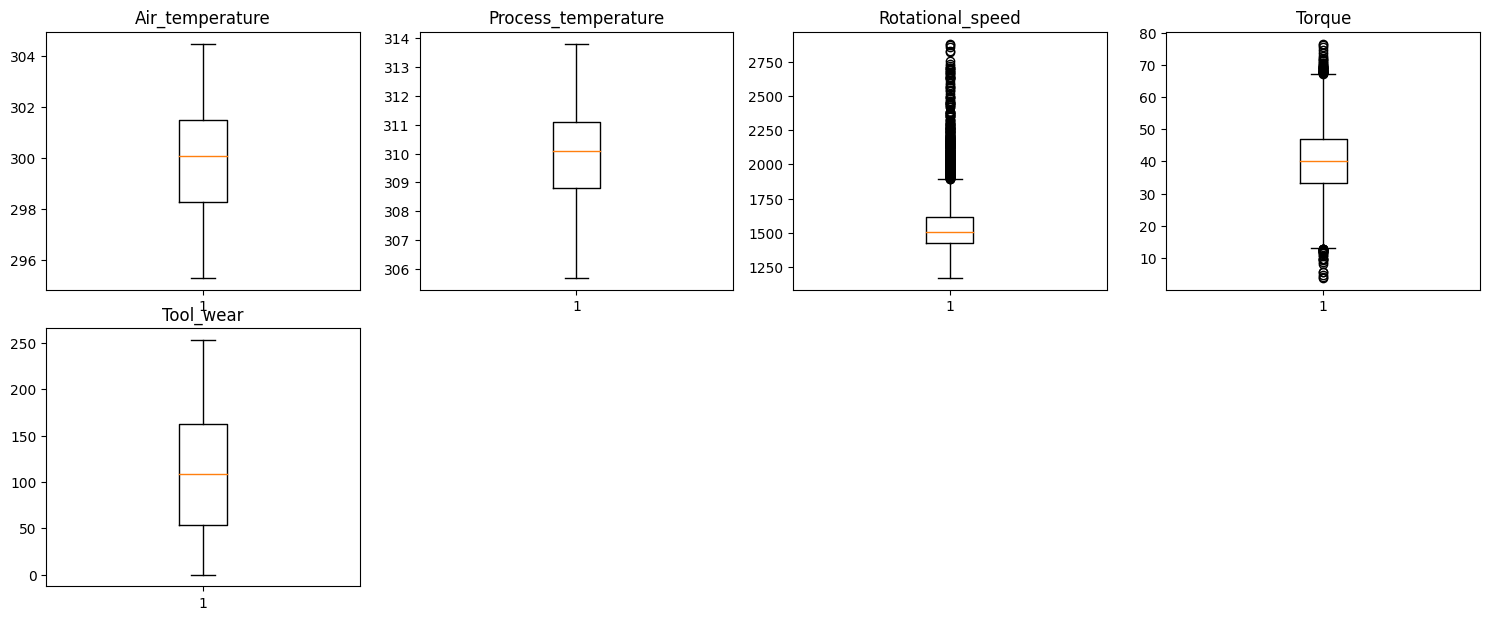

In [10]:
numeric_columns = df.select_dtypes(include=np.number).columns.tolist()
failure_columns = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'Machine_failure']
numeric_columns = [col for col in numeric_columns if col not in failure_columns]

plt.figure(figsize=(15, 12))

for i, variable in enumerate(numeric_columns):
    plt.subplot(4, 4, i + 1)
    plt.boxplot(df[variable], whis=1.5)
    plt.tight_layout()
    plt.title(variable)

plt.show()

There are outliers present in the dataset. However, no treatment will be applied as these are actual values observed.

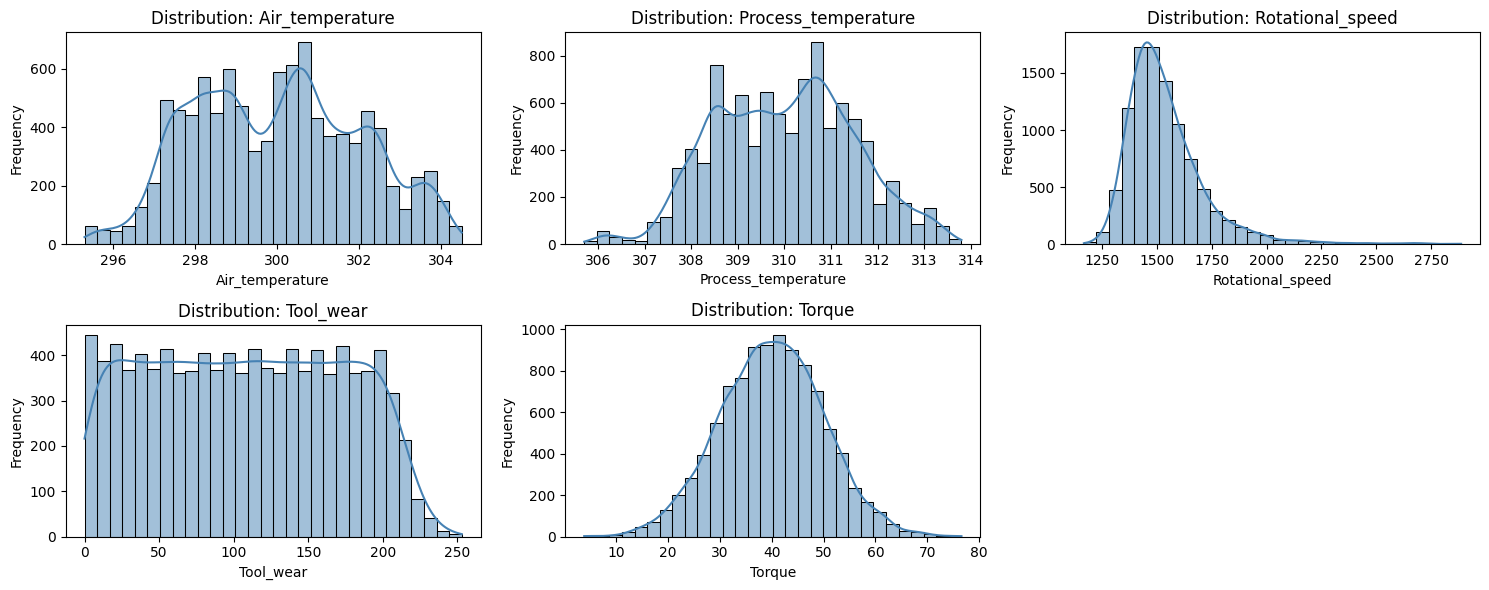

In [11]:
# Selecting sensor columns 
sensor_columns = df.select_dtypes(include='number').columns.difference(['Machine_failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF','Type'])


n_cols = 3
n_rows = int((len(sensor_columns) + n_cols - 1) / n_cols)
plt.figure(figsize=(n_cols * 5, n_rows * 3))

# Ploting each sensor column as a histogram
for idx, col in enumerate(sensor_columns):
    plt.subplot(n_rows, n_cols, idx + 1)
    sns.histplot(df[col], kde=True, bins=30, color='steelblue')
    plt.title(f'Distribution: {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

The rotational speed column is a right-skewed distribution rest are fairly normal distribution 

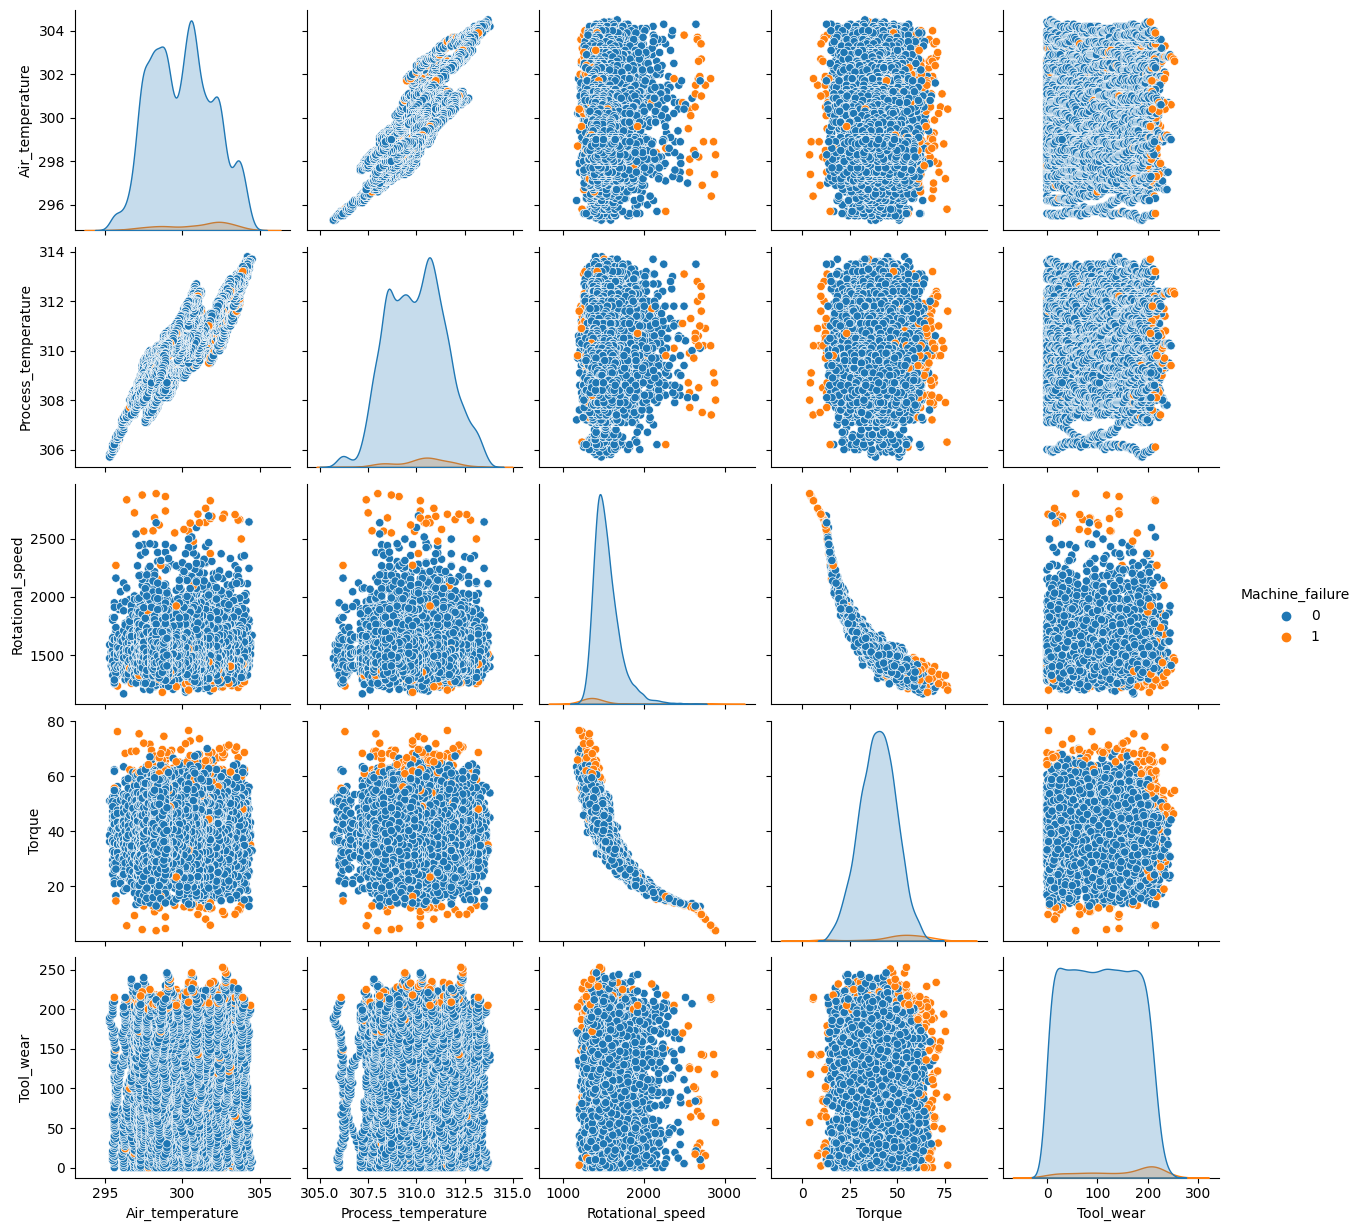

In [12]:
sns.pairplot(df.drop(['TWF','HDF','PWF','OSF','RNF'], axis=1),hue='Machine_failure')

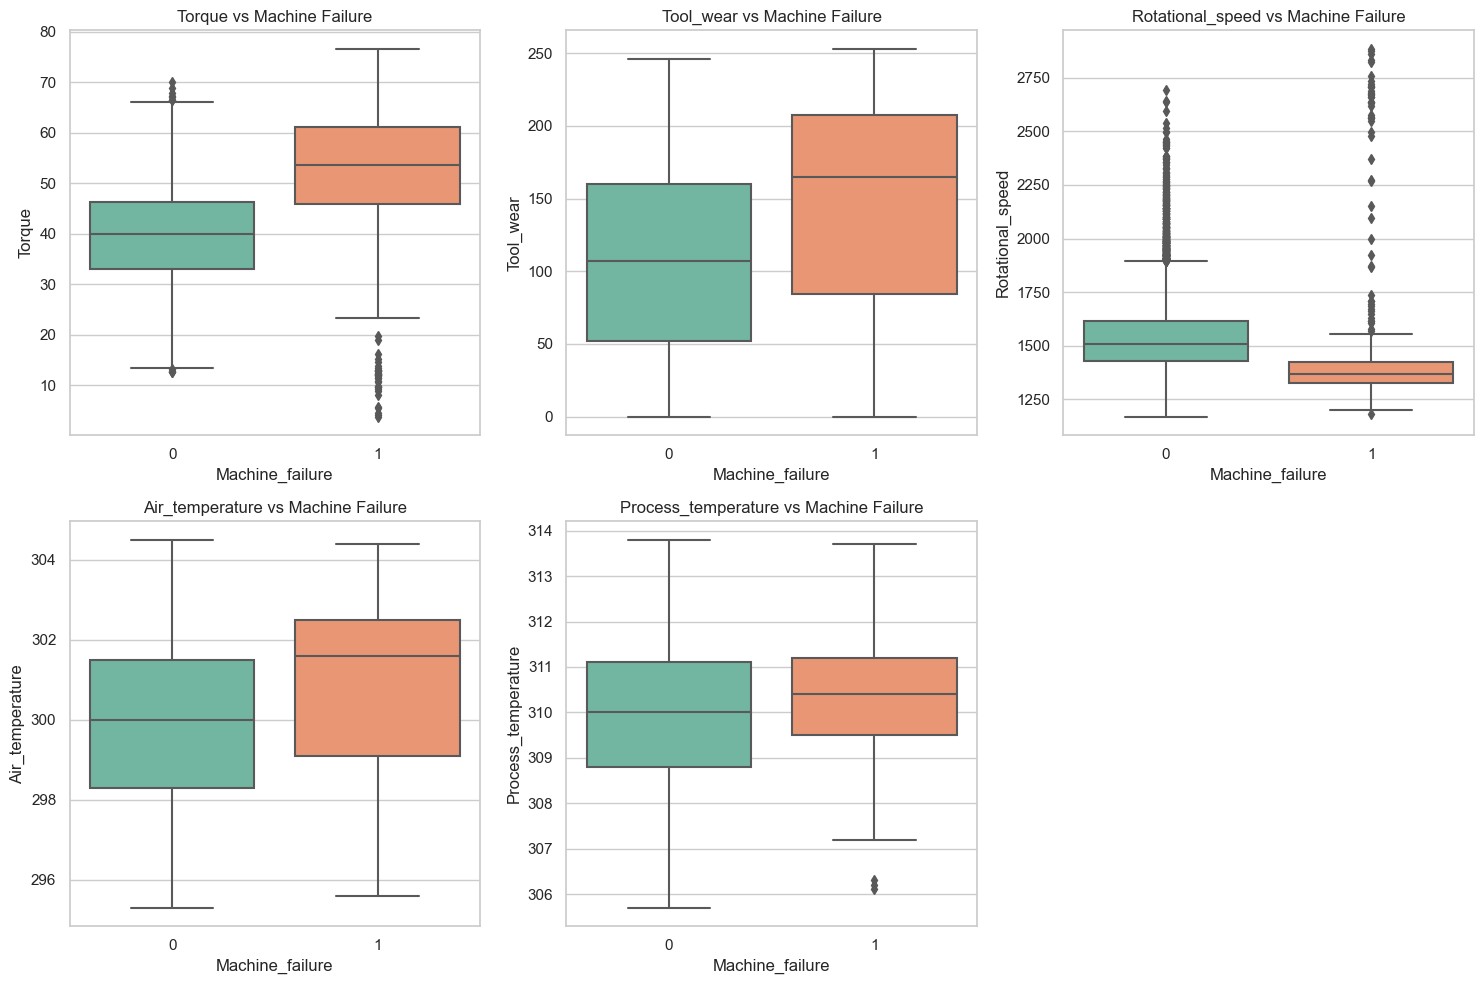

In [13]:
# Boxplots comparing sensor readings for failed vs non-failed machines.
sns.set(style="whitegrid")

# Features to compare
features_to_plot = ['Torque', 'Tool_wear', 'Rotational_speed',
                    'Air_temperature', 'Process_temperature']

plt.figure(figsize=(15, 10))

for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='Machine_failure', y=feature, data=df, palette='Set2')
    plt.title(f'{feature} vs Machine Failure')

plt.tight_layout()
plt.show()


More machine failures occur at **higher** air temperatures, process temperatures, torque and tool wear.


More machine failures occur at **lower** rotational speeds.

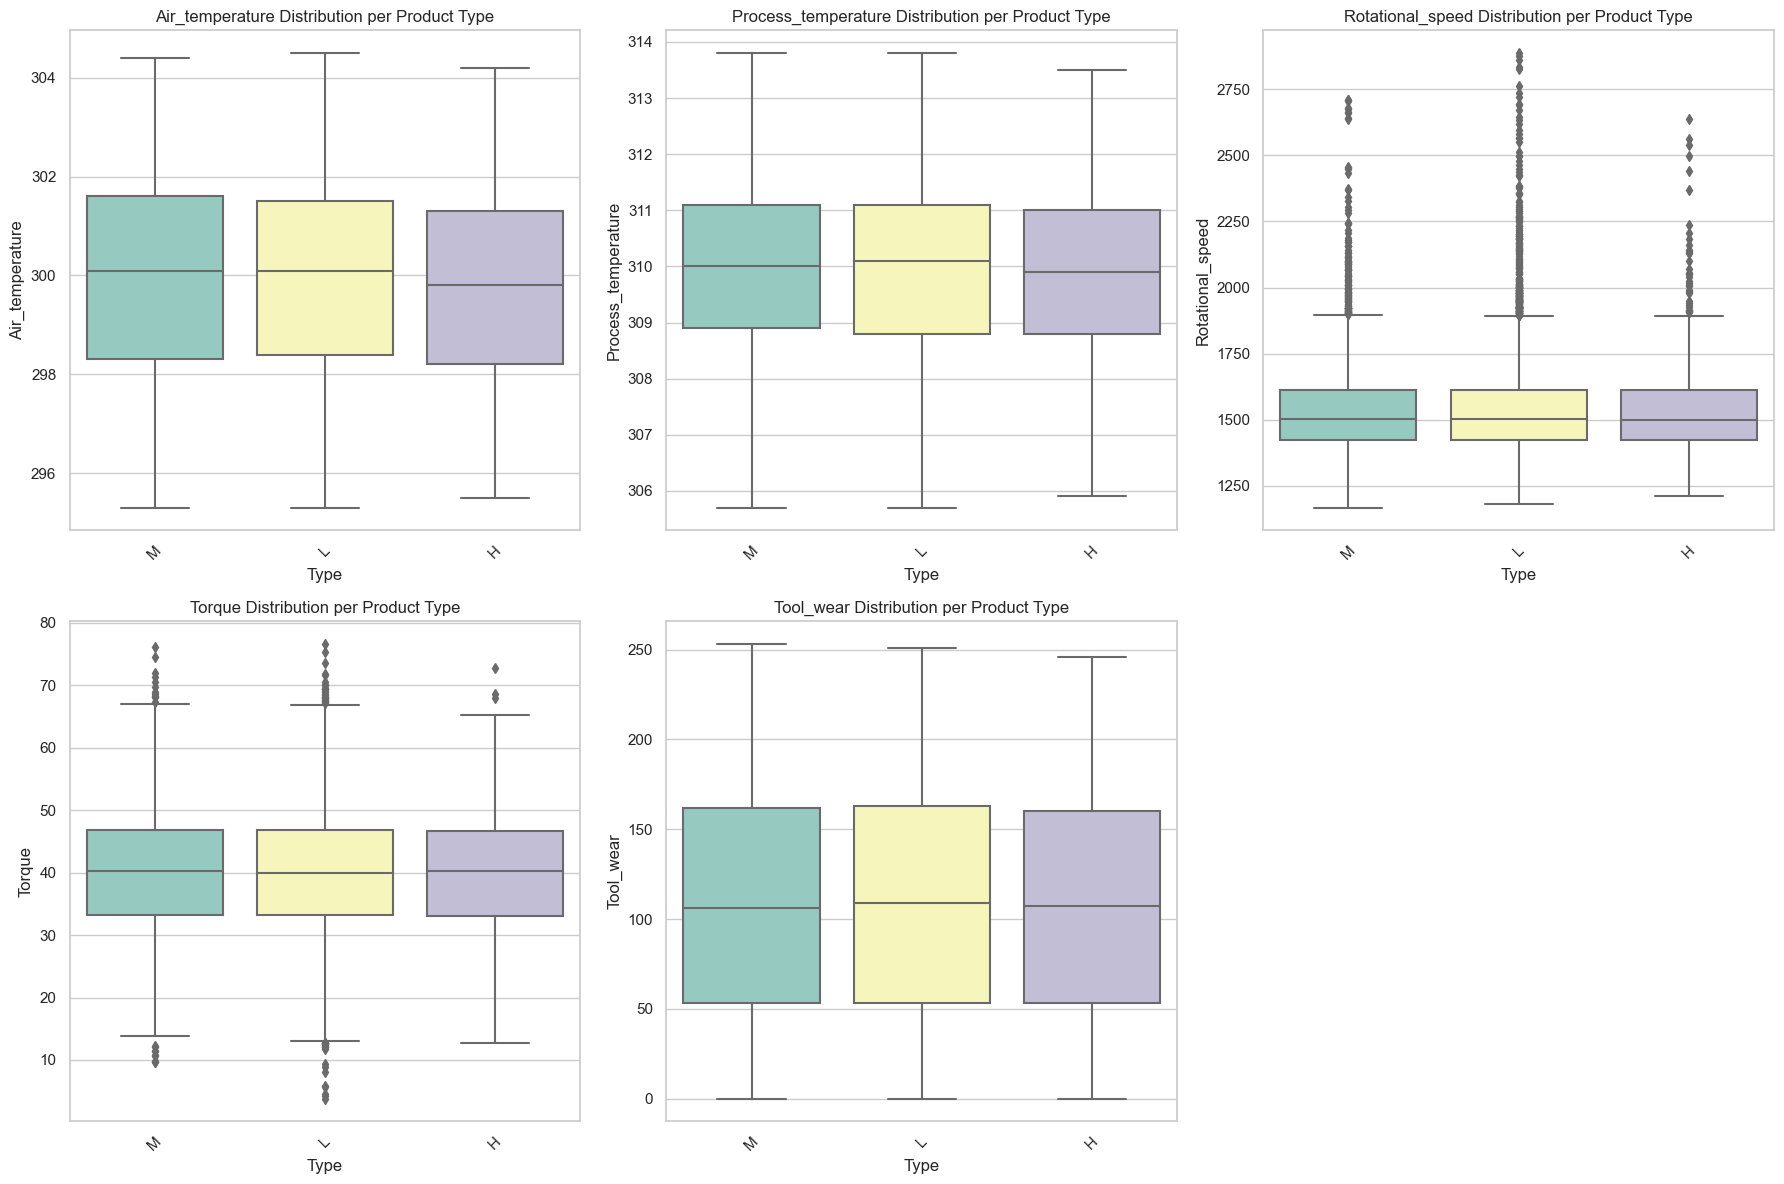

In [14]:
#Boxplots of All Sensor Inputs per Product Type
sensor_features = [
    'Air_temperature',
    'Process_temperature',
    'Rotational_speed',
    'Torque',
    'Tool_wear'
]

sns.set(style="whitegrid")

# Create subplots
plt.figure(figsize=(18, 12))

for i, feature in enumerate(sensor_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='Type', y=feature, data=df, palette='Set3')
    plt.title(f'{feature} Distribution per Product Type')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

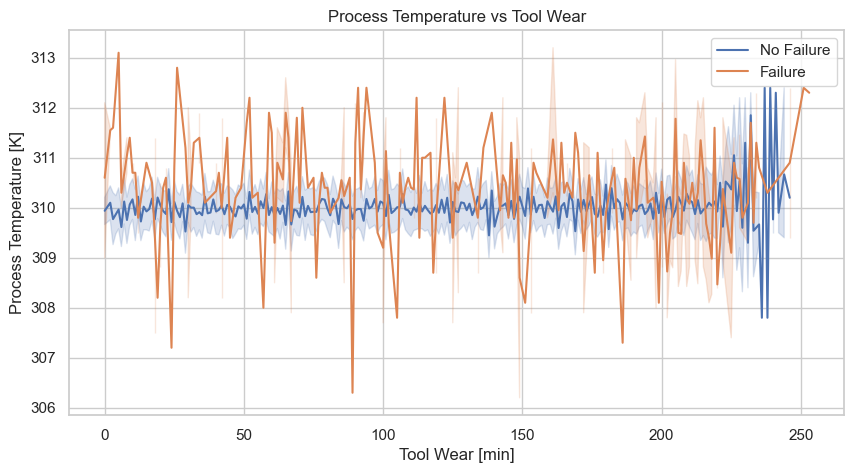

In [15]:


# --- Line Plot ---
plt.figure(figsize=(10, 5))
sns.lineplot(data=df[df["Machine_failure"] == 0], x="Tool_wear", y="Process_temperature", label="No Failure")
sns.lineplot(data=df[df["Machine_failure"] == 1], x="Tool_wear", y="Process_temperature", label="Failure")
plt.title("Process Temperature vs Tool Wear")
plt.xlabel("Tool Wear [min]")
plt.ylabel("Process Temperature [K]")
plt.legend()
plt.grid(True)
plt.show()


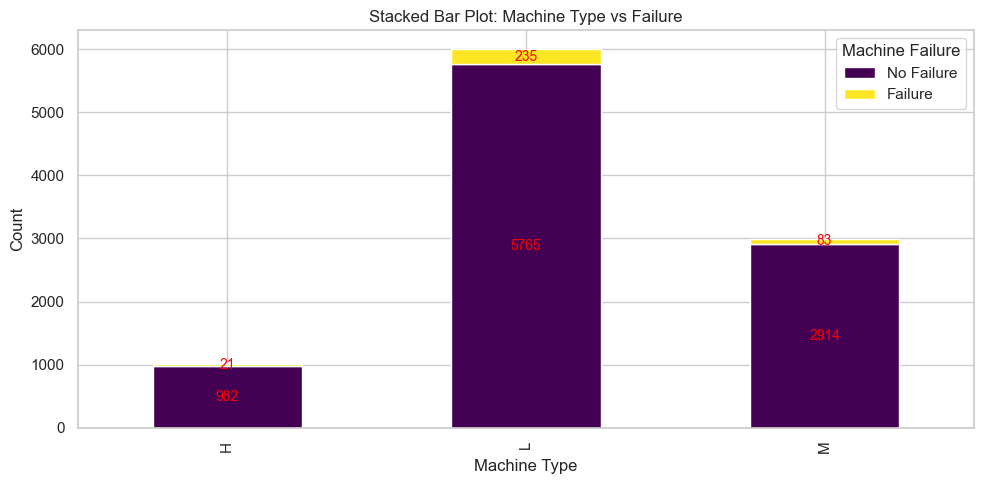

In [16]:
# failure  composition for each machine type
grouped = df.groupby(['Type', 'Machine_failure']).size().unstack(fill_value=0)

ax = grouped.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 5),
    colormap='viridis'
)

plt.title('Stacked Bar Plot: Machine Type vs Failure')
plt.xlabel('Machine Type')
plt.ylabel('Count')
plt.legend(title='Machine Failure', labels=['No Failure', 'Failure'])

# Add counts on top of bars
for i, (no_fail, fail) in enumerate(zip(grouped[0], grouped[1])):
    ax.text(i, no_fail / 2, str(no_fail), ha='center', va='center', color='red', fontsize=10)
    ax.text(i, no_fail + fail / 2, str(fail), ha='center', va='center', color='red', fontsize=10)

plt.tight_layout()
plt.show()

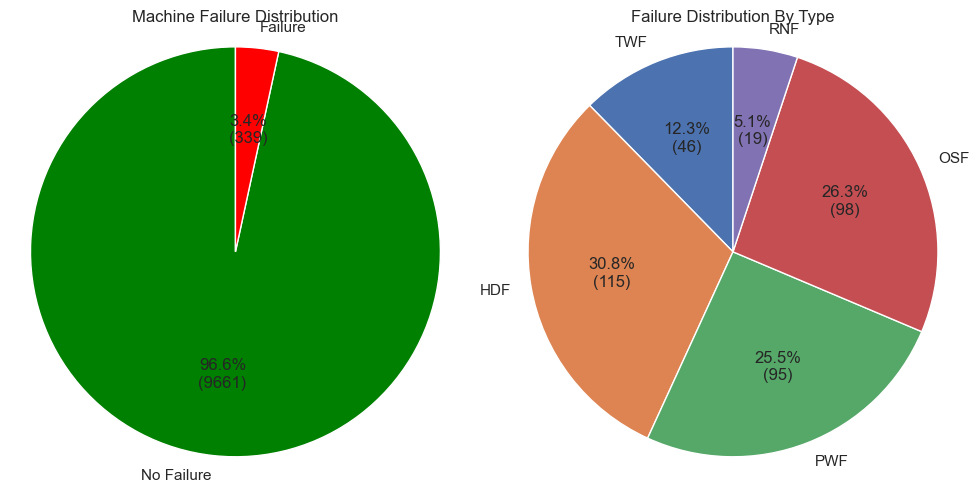

In [17]:
# Machine failure distribution
counts = df['Machine_failure'].value_counts()
labels = ['No Failure', 'Failure']
colors = ['green', 'red']

# Failure type distribution
failure_dist = df[['TWF', 'HDF', 'PWF', 'OSF', 'RNF']].sum()

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        count = int(round(pct * total / 100.0))
        return f'{pct:.1f}%\n({count})'
    return my_autopct

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# Plot 1: Machine Failure
axes[0].pie(
    counts,
    autopct=make_autopct(counts),
    startangle=90,
    labels=labels,
    colors=colors
)
axes[0].set_title('Machine Failure Distribution')
axes[0].axis('equal')  # Equal aspect ratio ensures pie is drawn as a circle.

# Plot 2: Failure Type
axes[1].pie(
    failure_dist,
    autopct=make_autopct(failure_dist.values),
    startangle=90,
    labels=failure_dist.index
)
axes[1].set_title('Failure Distribution By Type')
axes[1].axis('equal')

plt.tight_layout()
plt.show()

In [18]:
# Dominant Failure Type per Product Type

failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
dominant_failure = df.groupby('Type')[failure_types].sum().idxmax(axis=1)
print(dominant_failure)


Type
H    HDF
L    OSF
M    HDF
dtype: object


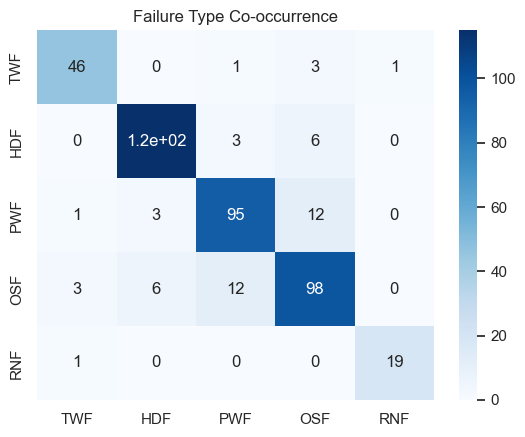

In [19]:

failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
co_matrix = df[failure_types].T.dot(df[failure_types])
sns.heatmap(co_matrix, annot=True, cmap='Blues')
plt.title('Failure Type Co-occurrence')
plt.show()


Text(0.5, 1.0, 'Feature Correlation Heatmap')

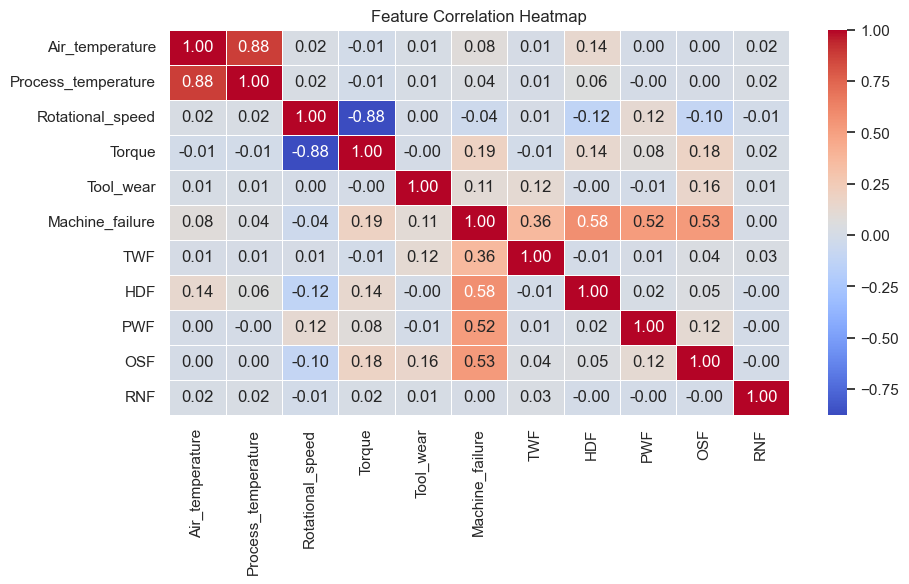

In [20]:
        plt.figure(figsize=(10, 5))
        numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
        correlation_matrix = df[numeric_cols].corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
        plt.title('Feature Correlation Heatmap')


Observation:

We see high **direct** correlation between process temperature and air temperature.

We see high **indirect** correlation between torque and rotational speed.

In [21]:

# Function to print potential thresholds
def threshold_summary(feature):
    print(f"\n--- {feature} ---")
    failed = df[df['Machine_failure'] == 1][feature]
    non_failed = df[df['Machine_failure'] == 0][feature]

    print(f"Failure Mean: {failed.mean():.2f}, 75th Percentile: {np.percentile(failed, 75):.2f}")
    print(f"No-Failure Mean: {non_failed.mean():.2f}, 75th Percentile: {np.percentile(non_failed, 75):.2f}")

  
# Features to evaluate
features_to_check = ['Torque', 'Tool_wear', 'Rotational_speed', 'Process_temperature', 'Air_temperature']

# Display thresholds
for feature in features_to_check:
    threshold_summary(feature)



--- Torque ---
Failure Mean: 50.17, 75th Percentile: 61.20
No-Failure Mean: 39.63, 75th Percentile: 46.30

--- Tool_wear ---
Failure Mean: 143.78, 75th Percentile: 207.50
No-Failure Mean: 106.69, 75th Percentile: 160.00

--- Rotational_speed ---
Failure Mean: 1496.49, 75th Percentile: 1421.50
No-Failure Mean: 1540.26, 75th Percentile: 1615.00

--- Process_temperature ---
Failure Mean: 310.29, 75th Percentile: 311.20
No-Failure Mean: 310.00, 75th Percentile: 311.10

--- Air_temperature ---
Failure Mean: 300.89, 75th Percentile: 302.50
No-Failure Mean: 299.97, 75th Percentile: 301.50


📈 **Clear Indicators of Failure Risk:**
1. Torque
  Higher values are more associated with failures.

 Recommendation: Monitor Torque > 50 Nm as an early alert for mechanical stress or potential failure.

2. Tool Wear
   Failure cases sharply increase at high wear values.

 Recommendation: Set alerts when Tool_wear > 200 min.

3. Rotational Speed
  Extreme speeds (too low or too high) correlate with failures.

  Recommendation: Monitor Rotational_speed < 1200 rpm or > 1700 rpm for abnormal operation.

4. Process Temperature
  Elevated process temperatures often coincide with failures.

  Recommendation: Set threshold alert when Process_temperature > 310 K.

5. Air Temperature
  Less sensitive but slightly higher in failure cases.

 Recommendation: Monitor if Air_temperature > 305 K, particularly with other anomalies.



In [22]:
#Dropping the failure type columns as there is not enough data for predicting failure type and the class balance is not desired further

failure_types = df[['TWF', 'HDF', 'PWF', 'OSF', 'RNF']]
df = df.drop(columns=[col for col in failure_types if col in df.columns])

In [23]:
 #Converting data type to numeric
 categorical_columns = df.select_dtypes(include=['object']).columns
 le = LabelEncoder()
 for col in categorical_columns:
       df[col] = le.fit_transform(df[col].astype(str))

**Model Training and Evaluation**

In [24]:
# Feature-target split
target_col = "Machine_failure"

X = df.drop(columns=[target_col])
y = df[target_col]

# Feature scaling 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


--- Random Forest ---
Accuracy: 0.98
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1939
           1       0.86      0.41      0.56        61

    accuracy                           0.98      2000
   macro avg       0.92      0.70      0.77      2000
weighted avg       0.98      0.98      0.98      2000



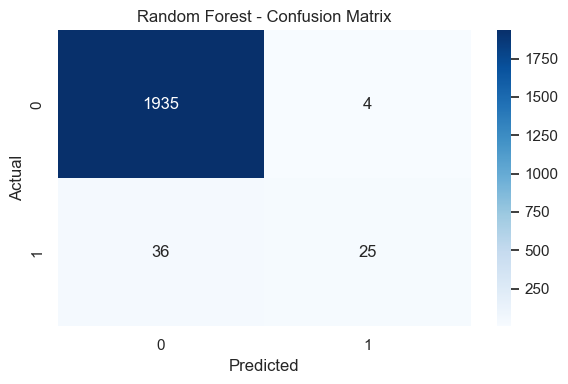

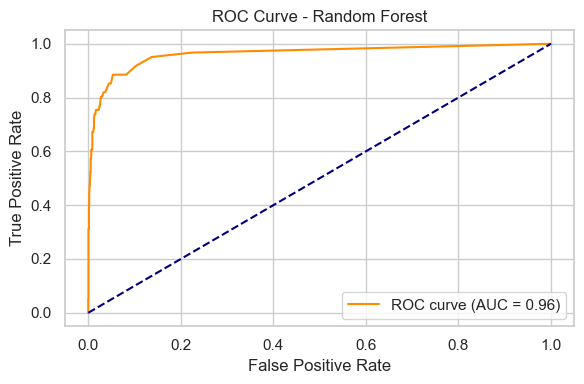

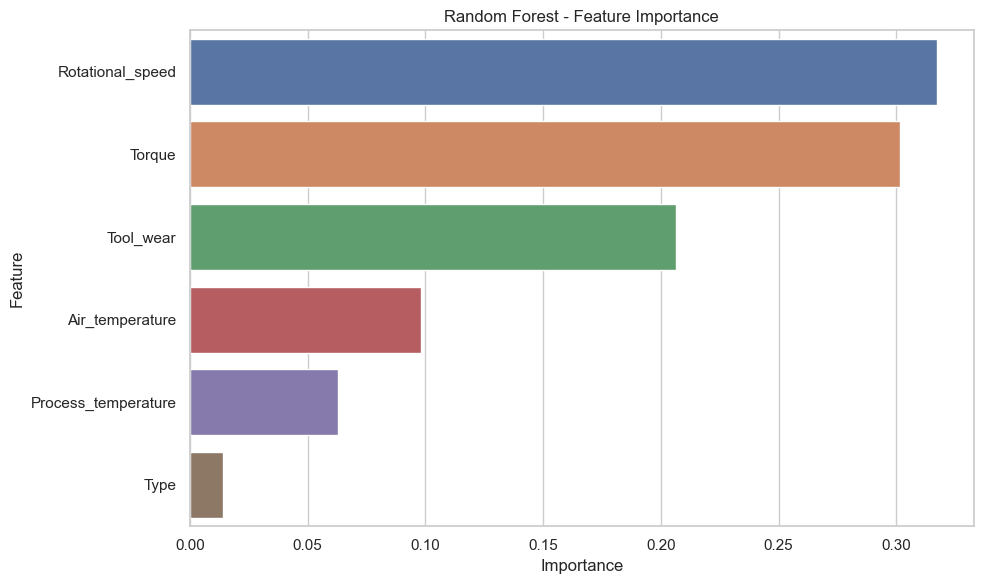


Top 5 Features - Random Forest:
               Feature  Importance
3     Rotational_speed    0.317099
4               Torque    0.301459
5            Tool_wear    0.206285
1      Air_temperature    0.098224
2  Process_temperature    0.062939
Mean Absolute Error (MAE): 0.0200
Root Mean Squared Error (RMSE): 0.1414


In [26]:
# === Random Forest Classifier ===
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Initialize classifier
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)

# Train model
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Accuracy & Classification Report
print("\n--- Random Forest ---")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# ROC Curve
y_pred_proba_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(6, 4))
plt.plot(fpr_rf, tpr_rf, label=f'ROC curve (AUC = {roc_auc_rf:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='navy')
plt.title('ROC Curve - Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# Feature Importance
importances_rf = rf.feature_importances_
feature_imp_rf = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances_rf
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_imp_rf)
plt.title('Random Forest - Feature Importance')
plt.tight_layout()
plt.show()

# Print Top 5 Features
print("\nTop 5 Features - Random Forest:")
print(feature_imp_rf.head())

# MAE
mae_rf = mean_absolute_error(y_test, y_pred_rf)
print(f"Mean Absolute Error (MAE): {mae_rf:.4f}")

def root_mean_square_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_lr = root_mean_square_error(y_test, y_pred_rf)
print(f"Root Mean Squared Error (RMSE): {rmse_lr:.4f}")


--- Logistic Regression ---
Accuracy: 0.8175
              precision    recall  f1-score   support

           0       0.99      0.82      0.90      1939
           1       0.13      0.85      0.22        61

    accuracy                           0.82      2000
   macro avg       0.56      0.83      0.56      2000
weighted avg       0.97      0.82      0.88      2000



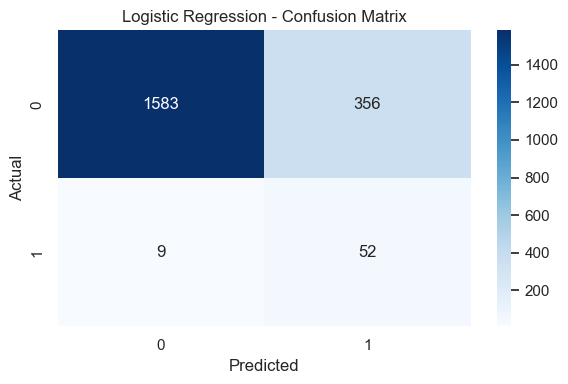

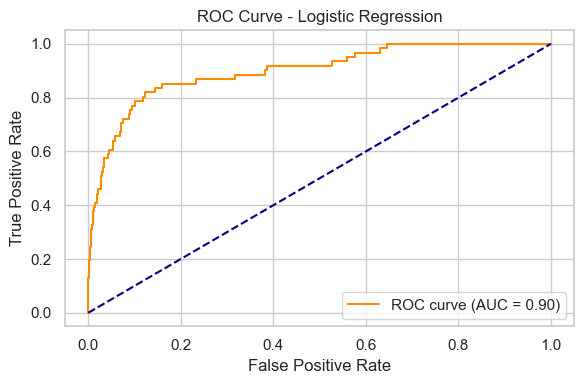


Beta 0 (Intercept): -1.5069
Beta 1 (Coefficients for each feature):
  Type: 0.0054
  Air_temperature: 1.7539
  Process_temperature: -1.1645
  Rotational_speed: 1.7661
  Torque: 2.4621
  Tool_wear: 0.9439
Mean Absolute Error (MAE): 0.1825
Root Mean Squared Error (RMSE): 0.4272


In [27]:
# === Logistic Regression Classifier ===
from sklearn.linear_model import LogisticRegression

# Initialize classifier
lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

# Train model
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Accuracy & Classification Report
print("\n--- Logistic Regression ---")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# ROC Curve
y_pred_proba_lr = lr.predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(6, 4))
plt.plot(fpr_lr, tpr_lr, label=f'ROC curve (AUC = {roc_auc_lr:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='navy')
plt.title('ROC Curve - Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# Print Beta Values (Intercept and Coefficients)
print(f"\nBeta 0 (Intercept): {lr.intercept_[0]:.4f}")
print("Beta 1 (Coefficients for each feature):")
for feature_name, coef in zip(X.columns, lr.coef_[0]):
    print(f"  {feature_name}: {coef:.4f}")

# MAE
mae_lr = mean_absolute_error(y_test, y_pred_lr)
print(f"Mean Absolute Error (MAE): {mae_lr:.4f}")

def root_mean_square_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_lr = root_mean_square_error(y_test, y_pred_lr)
print(f"Root Mean Squared Error (RMSE): {rmse_lr:.4f}")



--- SVM (Linear) ---
Accuracy: 0.8265
              precision    recall  f1-score   support

           0       0.99      0.83      0.90      1939
           1       0.13      0.85      0.23        61

    accuracy                           0.83      2000
   macro avg       0.56      0.84      0.57      2000
weighted avg       0.97      0.83      0.88      2000



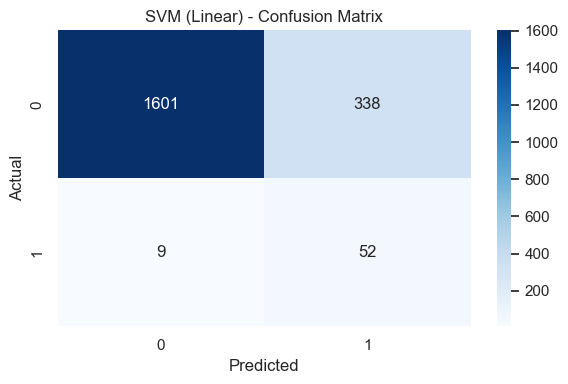

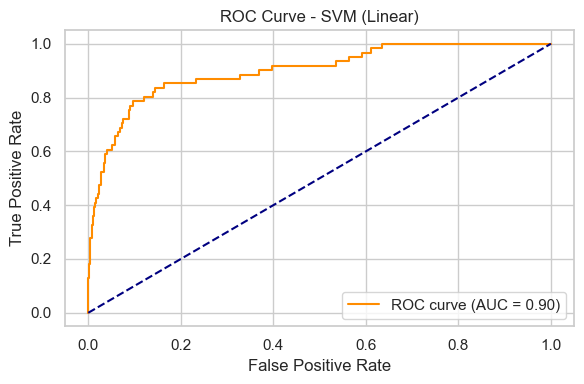

Mean Absolute Error (MAE): 0.1735
Root Mean Squared Error (RMSE): 0.4272


In [28]:
# === SVM (Linear) Classifier ===
from sklearn.svm import SVC

# Initialize classifier
svm = SVC(kernel='linear', probability=True, class_weight='balanced', random_state=42)

# Train model
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

# Accuracy & Classification Report
print("\n--- SVM (Linear) ---")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', cmap='Blues')
plt.title('SVM (Linear) - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# ROC Curve
y_pred_proba_svm = svm.predict_proba(X_test)[:, 1]
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_proba_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure(figsize=(6, 4))
plt.plot(fpr_svm, tpr_svm, label=f'ROC curve (AUC = {roc_auc_svm:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='navy')
plt.title('ROC Curve - SVM (Linear)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# MAE
mae_svm = mean_absolute_error(y_test, y_pred_svm)
print(f"Mean Absolute Error (MAE): {mae_svm:.4f}")

def root_mean_square_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_lr = root_mean_square_error(y_test, y_pred_lr)
print(f"Root Mean Squared Error (RMSE): {rmse_lr:.4f}")



Of the 3 models the **Random Forest** performs the better considering the **accuracy** but for machine failure detection, **high recall** is generally more important than **high precision**. 

The reason is that the cost of a false negative (failing to detect a failure) is significantly higher than the cost of a false positive (incorrectly predicting a failure). A false negative could lead to costly downtime, damage to equipment, or safety hazards, while a false positive might just require a minor check-up that is later dismissed. 

So in that context **SVM** is the the **prefered** model as it gives a better recall on the imbalanced **class 1(failure).**

**Cross Validation**

In [29]:

# === Cross-validation configuration ===
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC()
}

for name, clf in classifiers.items():
    print(f"\n--- {name} ---")
    
    # Accuracy from cross-validation
    scores = cross_val_score(clf, X_scaled, y, cv=cv, scoring='accuracy')
    print(f"Cross-Validation Accuracy Scores: {scores}")
    print(f"Mean Accuracy: {scores.mean():.4f} | Std Dev: {scores.std():.4f}")



--- Logistic Regression ---
Cross-Validation Accuracy Scores: [0.9705 0.969  0.969  0.972  0.971 ]
Mean Accuracy: 0.9703 | Std Dev: 0.0012

--- Random Forest ---
Cross-Validation Accuracy Scores: [0.9845 0.986  0.983  0.9855 0.9815]
Mean Accuracy: 0.9841 | Std Dev: 0.0017

--- SVM ---
Cross-Validation Accuracy Scores: [0.9745 0.9745 0.971  0.9755 0.974 ]
Mean Accuracy: 0.9739 | Std Dev: 0.0015


## 📊 Model Performance Comparison

| Metric                     | Random Forest | Logistic Regression | SVM (Linear) |
|----------------------------|----------------|----------------------|---------------|
| **Accuracy**               | **0.98**       | 0.82                 | 0.83          |
| **Precision (Class 1)**    | **0.74**       | 0.13                 | 0.13          |
| **Recall (Class 1)**       | 0.38           | **0.84**             | **0.84**      |
| **F1-Score (Class 1)**     | **0.50**       | 0.23                 | 0.23          |
| **Macro Avg F1-Score**     | **0.74**       | 0.56                 | 0.56          |

### 🔍 Observations:
- **Random Forest** performs best in terms of **overall accuracy** and **precision**, making it reliable when **false positives must be minimized**.
- **Logistic Regression** and **SVM** offer **high recall**, ensuring most failures are caught, but at the cost of **many false alarms** (low precision).
- Choose the model based on your priority:
  - Prioritize **catching all failures?** → Use **Logistic Regression/SVM**
  - Prefer a **balanced and robust model?** → Use **Random Forest**


**Sample Testing**

In [30]:
import joblib

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
clf.fit(X_train, y_train)
...
if name == 'SVM':
    joblib.dump(clf, 'model.pkl')
    feature_cols = ['Type', 'Air_temperature', 'Process_temperature', 
                'Rotational_speed', 'Torque', 'Tool_wear']
    
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(feature_cols, 'feature_order.pkl')

['feature_order.pkl']

In [47]:
model = joblib.load('model.pkl')
scaler = joblib.load('scaler.pkl')
feature_order = joblib.load('feature_order.pkl')

# Sample test input
test_input = pd.DataFrame([{
    'Type': 1,
    'Air_temperature': 298,
    'Process_temperature': 309.3,
    'Rotational_speed': 1405,
    'Torque': 68.7,
    'Tool_wear': 210
}])

# Reorder and scale
test_input = test_input[feature_order]
test_input_scaled = scaler.transform(test_input)

# Predict
prediction = model.predict(test_input_scaled)
print("Prediction:", prediction[0])  # 0 or 1

Prediction: 1
